In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
ticker = "AAPL"
data = yf.download(ticker, start="2010-01-01", end="2023-12-31")
close_prices = data['Close'].values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [6]:
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

In [7]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [17]:
class Time2Vec(layers.Layer):
    def __init__(self, kernel_size=257):  
        super(Time2Vec, self).__init__()
        self.k = kernel_size
    
    def build(self, input_shape):
        self.wb = self.add_weight(shape=(input_shape[-1], self.k),
                                  initializer='uniform',
                                  trainable=True,
                                  name='wb')
        self.bb = self.add_weight(shape=(self.k,),
                                  initializer='uniform',
                                  trainable=True,
                                  name='bb')
        self.wa = self.add_weight(shape=(input_shape[-1], 1),
                                  initializer='uniform',
                                  trainable=True,
                                  name='wa')
        self.ba = self.add_weight(shape=(1,),
                                  initializer='uniform',
                                  trainable=True,
                                  name='ba')
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs):
        bias = self.wb * inputs + self.bb
        dp = keras.backend.dot(inputs, self.wa) + self.ba
        wgts = keras.backend.sin(bias)
        return keras.backend.concatenate([dp, wgts], -1)


In [18]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    time_embedding = Time2Vec(kernel_size=head_size)(inputs)
    x = layers.Concatenate()([inputs, time_embedding])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    attn_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(attn_output)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + inputs

In [20]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [21]:
input_shape = X_train.shape[1:]
model = build_model(
    input_shape,
    head_size=257, 
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128, 64],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [22]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [23]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 63s 591ms/step - loss: 7.0790 - mae: 1.8756 - val_loss: 0.2954 - val_mae: 0.5292
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 508ms/step - loss: 0.1706 - mae: 0.3219 - val_loss: 0.2788 - val_mae: 0.5130
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 493ms/step - loss: 0.0274 - mae: 0.1268 - val_loss: 0.2969 - val_mae: 0.5253
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 467ms/step - loss: 0.0121 - mae: 0.0826 - val_loss: 0.2555 - val_mae: 0.4865
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 495ms/step - loss: 0.0093 - mae: 0.0714 - val_loss: 0.2094 - val_mae: 0.4389
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 54s 694ms/step - loss: 0.0075 - mae: 0.0615 - val_loss: 0.1461 - val_mae: 0.3628
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 476ms/step - loss: 0.0050 - mae: 0.0495 - val_loss: 0.0952 - val_mae: 0.2879
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 467ms/step - loss: 0.0041 - mae: 0.0429 - val_loss: 0.0701 - val_mae: 0.2446
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 461ms/

In [24]:
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()

87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step


In [25]:
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_train_actual = scaler.inverse_transform(y_train).flatten()
y_test_actual = scaler.inverse_transform(y_test).flatten()

In [26]:
prediction_std = np.std(y_test_actual - test_predictions)
lower_bound = test_predictions - 1.96 * prediction_std
upper_bound = test_predictions + 1.96 * prediction_std

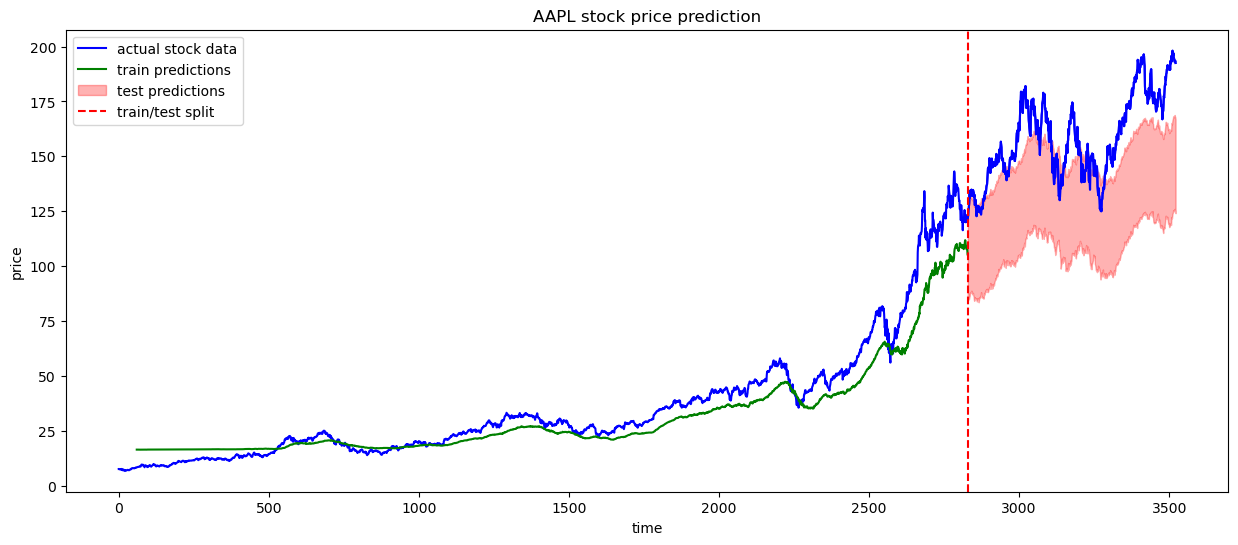

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(close_prices, label='actual stock data', color='blue')
split_point = train_size + sequence_length
plt.plot(range(sequence_length, split_point), train_predictions, label='train predictions', color='green')
plt.fill_between(range(split_point, len(close_prices)), 
                 lower_bound, 
                 upper_bound, 
                 color='red', 
                 alpha=0.3, 
                 label='test predictions')
plt.plot(range(split_point, len(close_prices)), y_test_actual, color='blue')
plt.axvline(x=split_point, color='r', linestyle='--', label='train/test split')
plt.title(f'{ticker} stock price prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [29]:
train_mse = mean_squared_error(y_train_actual, train_predictions)
test_mse = mean_squared_error(y_test_actual, test_predictions)
train_mae = mean_absolute_error(y_train_actual, train_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)

In [30]:
print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Train MSE: 80.73
Test MSE: 1060.05
Train MAE: 6.45
Test MAE: 30.67
